In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_selection import SelectKBest, chi2


In [21]:
# Load the dataset
df = pd.read_csv('../data_collection/data/nhs/phobia_symptoms_combined_dataset.csv')
df.head()

,Symptom,Type,Associated Phobia
0,sweating,Physical,"General Phobia, Social Phobia, Claustrophobia"
1,trembling,Physical,"General Phobia, Social Phobia, Claustrophobia"
2,hot flushes or chills,Physical,"General Phobia, Social Phobia, Claustrophobia"
3,shortness of breath,Physical,"General Phobia, Agoraphobia, Claustrophobia"
4,difficulty breathing,Physical,"General Phobia, Agoraphobia, Claustrophobia"


In [22]:
# Combine all symptom-related features into one text feature (if necessary)
df['text'] = df['Symptom'].astype(str)
df.head()

,Symptom,Type,Associated Phobia,text
0,sweating,Physical,"General Phobia, Social Phobia, Claustrophobia",sweating
1,trembling,Physical,"General Phobia, Social Phobia, Claustrophobia",trembling
2,hot flushes or chills,Physical,"General Phobia, Social Phobia, Claustrophobia",hot flushes or chills
3,shortness of breath,Physical,"General Phobia, Agoraphobia, Claustrophobia",shortness of breath
4,difficulty breathing,Physical,"General Phobia, Agoraphobia, Claustrophobia",difficulty breathing


In [23]:
# Encode the target labels (Phobia types)
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['Associated Phobia'])
df.head()

,Symptom,Type,Associated Phobia,text,label
0,sweating,Physical,"General Phobia, Social Phobia, Claustrophobia",sweating,4
1,trembling,Physical,"General Phobia, Social Phobia, Claustrophobia",trembling,4
2,hot flushes or chills,Physical,"General Phobia, Social Phobia, Claustrophobia",hot flushes or chills,4
3,shortness of breath,Physical,"General Phobia, Agoraphobia, Claustrophobia",shortness of breath,2
4,difficulty breathing,Physical,"General Phobia, Agoraphobia, Claustrophobia",difficulty breathing,2


In [24]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42)


In [25]:
# Convert text data into TF-IDF features
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), stop_words='english')
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

## Logistic Regression

In [28]:
# Logistic Regression
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_tfidf, y_train)

# Predict on the test set
y_pred_lr = lr_model.predict(X_test_tfidf)

# Evaluate Logistic Regression
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
unique_labels = sorted(list(set(y_test)))
print(classification_report(y_test, y_pred_lr, target_names=label_encoder.inverse_transform(unique_labels)))


Logistic Regression Accuracy: 0.375
                                precision    recall  f1-score   support

                   Agoraphobia       0.00      0.00      0.00         2
General Phobia, Claustrophobia       0.43      1.00      0.60         3
                 Social Phobia       0.00      0.00      0.00         3

                      accuracy                           0.38         8
                     macro avg       0.14      0.33      0.20         8
                  weighted avg       0.16      0.38      0.22         8



/Users/piyush/Classes/Web Dev/Abdirahin/Chatbot/env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/piyush/Classes/Web Dev/Abdirahin/Chatbot/env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/piyush/Classes/Web Dev/Abdirahin/Chatbot/env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

## Random Forest with Hyperparameter Tuning

In [29]:
# Random Forest with Hyperparameter Tuning
rf_model = RandomForestClassifier(random_state=42)

# Define the parameter grid for RandomizedSearchCV
param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# RandomizedSearchCV for hyperparameter tuning
random_search = RandomizedSearchCV(rf_model, param_distributions=param_dist, 
                                   n_iter=10, cv=3, random_state=42, n_jobs=-1)

random_search.fit(X_train_tfidf, y_train)

# Get the best model
best_rf_model = random_search.best_estimator_

# Predict on the test set with the best Random Forest model
y_pred_rf = best_rf_model.predict(X_test_tfidf)

# Evaluate Random Forest
print("Best Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf, target_names=label_encoder.inverse_transform(unique_labels)))


/Users/piyush/Classes/Web Dev/Abdirahin/Chatbot/env/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


Best Random Forest Accuracy: 0.375
                                precision    recall  f1-score   support

                   Agoraphobia       0.00      0.00      0.00         2
General Phobia, Claustrophobia       0.43      1.00      0.60         3
                 Social Phobia       0.00      0.00      0.00         3

                      accuracy                           0.38         8
                     macro avg       0.14      0.33      0.20         8
                  weighted avg       0.16      0.38      0.22         8



/Users/piyush/Classes/Web Dev/Abdirahin/Chatbot/env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/piyush/Classes/Web Dev/Abdirahin/Chatbot/env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/piyush/Classes/Web Dev/Abdirahin/Chatbot/env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

## Support Vector Machine (SVM)

In [30]:
# SVM Model
svm_model = SVC(kernel='linear', C=1, random_state=42)
svm_model.fit(X_train_tfidf, y_train)

# Predict on the test set
y_pred_svm = svm_model.predict(X_test_tfidf)

# Evaluate SVM
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm, target_names=label_encoder.inverse_transform(unique_labels)))


SVM Accuracy: 0.375
                                precision    recall  f1-score   support

                   Agoraphobia       0.00      0.00      0.00         2
General Phobia, Claustrophobia       0.43      1.00      0.60         3
                 Social Phobia       0.00      0.00      0.00         3

                      accuracy                           0.38         8
                     macro avg       0.14      0.33      0.20         8
                  weighted avg       0.16      0.38      0.22         8



/Users/piyush/Classes/Web Dev/Abdirahin/Chatbot/env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/piyush/Classes/Web Dev/Abdirahin/Chatbot/env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/piyush/Classes/Web Dev/Abdirahin/Chatbot/env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

## Feature Selection

In [32]:
# Feature Selection with Chi-Squared
selector = SelectKBest(chi2, k=2000)
X_train_selected = selector.fit_transform(X_train_tfidf, y_train)
X_test_selected = selector.transform(X_test_tfidf)

# Train Random Forest with selected features
best_rf_model.fit(X_train_selected, y_train)
y_pred_selected_rf = best_rf_model.predict(X_test_selected)

# Evaluate Random Forest with Feature Selection
print("Random Forest with Feature Selection Accuracy:", accuracy_score(y_test, y_pred_selected_rf))
print(classification_report(y_test, y_pred_selected_rf, target_names=label_encoder.inverse_transform(unique_labels)))


Random Forest with Feature Selection Accuracy: 0.375
                                precision    recall  f1-score   support

                   Agoraphobia       0.00      0.00      0.00         2
General Phobia, Claustrophobia       0.43      1.00      0.60         3
                 Social Phobia       0.00      0.00      0.00         3

                      accuracy                           0.38         8
                     macro avg       0.14      0.33      0.20         8
                  weighted avg       0.16      0.38      0.22         8



/Users/piyush/Classes/Web Dev/Abdirahin/Chatbot/env/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=2000 is greater than n_features=73. All the features will be returned.
  warnings.warn(
/Users/piyush/Classes/Web Dev/Abdirahin/Chatbot/env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/piyush/Classes/Web Dev/Abdirahin/Chatbot/env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/piyush/Classes/Web Dev/Abdirahin/Chat

## Compare Model Performance

In [33]:
# Summary of Accuracies
print("Model Performance Summary:")
print(f"Logistic Regression Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print(f"Best Random Forest Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"SVM Accuracy: {accuracy_score(y_test, y_pred_svm):.4f}")
print(f"Random Forest with Feature Selection Accuracy: {accuracy_score(y_test, y_pred_selected_rf):.4f}")


Model Performance Summary:
Logistic Regression Accuracy: 0.3750
Best Random Forest Accuracy: 0.3750
SVM Accuracy: 0.3750
Random Forest with Feature Selection Accuracy: 0.3750


## Testing Model

Accuracy: 0.3750
Classification Report:
                                precision    recall  f1-score   support

                   Agoraphobia       0.00      0.00      0.00         2
General Phobia, Claustrophobia       0.43      1.00      0.60         3
                 Social Phobia       0.00      0.00      0.00         3

                      accuracy                           0.38         8
                     macro avg       0.14      0.33      0.20         8
                  weighted avg       0.16      0.38      0.22         8



/Users/piyush/Classes/Web Dev/Abdirahin/Chatbot/env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/piyush/Classes/Web Dev/Abdirahin/Chatbot/env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/piyush/Classes/Web Dev/Abdirahin/Chatbot/env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

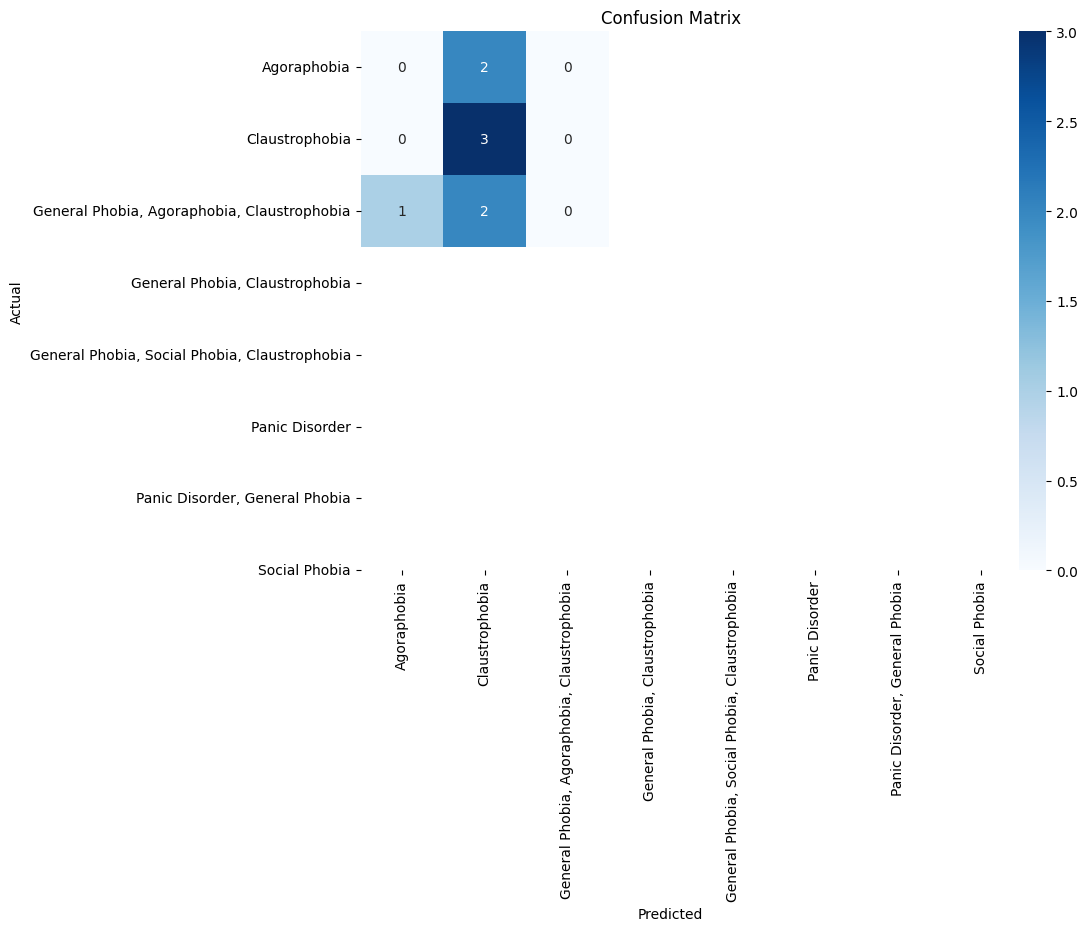

In [35]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Make predictions on the test set
y_pred = best_rf_model.predict(X_test_tfidf)  

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Generate a classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.inverse_transform(unique_labels)))

# Optional: Plot a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


## Testing all implemneted models

In [38]:
models = {
    "Logistic Regression": lr_model,
    "Random Forest": best_rf_model,
    "SVM": svm_model
}

for model_name, model in models.items():
    print(f"\nTesting {model_name}:")
    y_pred = model.predict(X_test_tfidf)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
    print(classification_report(y_test, y_pred_selected_rf, target_names=label_encoder.inverse_transform(unique_labels)))



Testing Logistic Regression:
Accuracy: 0.3750
                                precision    recall  f1-score   support

                   Agoraphobia       0.00      0.00      0.00         2
General Phobia, Claustrophobia       0.43      1.00      0.60         3
                 Social Phobia       0.00      0.00      0.00         3

                      accuracy                           0.38         8
                     macro avg       0.14      0.33      0.20         8
                  weighted avg       0.16      0.38      0.22         8


Testing Random Forest:
Accuracy: 0.3750
                                precision    recall  f1-score   support

                   Agoraphobia       0.00      0.00      0.00         2
General Phobia, Claustrophobia       0.43      1.00      0.60         3
                 Social Phobia       0.00      0.00      0.00         3

                      accuracy                           0.38         8
                     macro avg       0.14  

/Users/piyush/Classes/Web Dev/Abdirahin/Chatbot/env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/piyush/Classes/Web Dev/Abdirahin/Chatbot/env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/piyush/Classes/Web Dev/Abdirahin/Chatbot/env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

## Model preparation

In [39]:
import joblib

# Save the model
joblib.dump(best_rf_model, 'phobia_detection_model.pkl')
# Save the TF-IDF vectorizer
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')
# Save the label encoder
joblib.dump(label_encoder, 'label_encoder.pkl')


['label_encoder.pkl']

## Load the Model and Supporting Objects

In [40]:
import joblib
import numpy as np

# Load the model
model = joblib.load('phobia_detection_model.pkl')
# Load the TF-IDF vectorizer
tfidf_vectorizer = joblib.load('tfidf_vectorizer.pkl')
# Load the label encoder
label_encoder = joblib.load('label_encoder.pkl')


## Create a Function to Process User Input

In [41]:
def predict_phobia(user_input):
    # Transform the user input using the TF-IDF vectorizer
    user_input_tfidf = tfidf_vectorizer.transform([user_input])
    
    # Make a prediction using the loaded model
    prediction = model.predict(user_input_tfidf)
    
    # Decode the predicted label to get the associated phobia
    predicted_phobia = label_encoder.inverse_transform(prediction)[0]
    
    return predicted_phobia


In [50]:
import pandas as pd

symptom_weights = {
    "sweating": {
        "general phobia": 1.0,
        "social phobia": 1.0,
        "claustrophobia": 1.0,
        "agoraphobia": 0.0,
        "panic disorder": 0.0
    },
    "trembling": {
        "general phobia": 1.0,
        "social phobia": 1.0,
        "claustrophobia": 1.0,
        "agoraphobia": 0.0,
        "panic disorder": 0.0
    },
    "hot flushes or chills": {
        "general phobia": 1.0,
        "social phobia": 1.0,
        "claustrophobia": 1.0,
        "agoraphobia": 0.0,
        "panic disorder": 0.0
    },
    "shortness of breath": {
        "general phobia": 1.0,
        "agoraphobia": 1.0,
        "claustrophobia": 1.0,
        "social phobia": 0.0,
        "panic disorder": 0.0
    },
    "difficulty breathing": {
        "general phobia": 1.0,
        "agoraphobia": 1.0,
        "claustrophobia": 1.0,
        "social phobia": 0.0,
        "panic disorder": 0.0
    },
    "choking sensation": {
        "general phobia": 1.0,
        "claustrophobia": 1.0,
        "agoraphobia": 0.0,
        "social phobia": 0.0,
        "panic disorder": 0.0
    },
    "rapid heartbeat": {
        "general phobia": 1.0,
        "social phobia": 1.0,
        "claustrophobia": 1.0,
        "agoraphobia": 0.0,
        "panic disorder": 0.0
    },
    "pain or tightness in the chest": {
        "general phobia": 1.0,
        "claustrophobia": 1.0,
        "agoraphobia": 0.0,
        "social phobia": 0.0,
        "panic disorder": 0.0
    },
    "sensation of butterflies in the stomach": {
        "general phobia": 1.0,
        "claustrophobia": 1.0,
        "agoraphobia": 0.0,
        "social phobia": 0.0,
        "panic disorder": 0.0
    },
    "nausea": {
        "general phobia": 1.0,
        "claustrophobia": 1.0,
        "agoraphobia": 0.0,
        "social phobia": 0.0,
        "panic disorder": 0.0
    },
    "headaches and dizziness": {
        "general phobia": 1.0,
        "claustrophobia": 1.0,
        "agoraphobia": 0.0,
        "social phobia": 0.0,
        "panic disorder": 0.0
    },
    "feeling faint": {
        "general phobia": 1.0,
        "claustrophobia": 1.0,
        "agoraphobia": 0.0,
        "social phobia": 0.0,
        "panic disorder": 0.0
    },
    "numbness or pins and needles": {
        "general phobia": 1.0,
        "claustrophobia": 1.0,
        "agoraphobia": 0.0,
        "social phobia": 0.0,
        "panic disorder": 0.0
    },
    "dry mouth": {
        "general phobia": 1.0,
        "claustrophobia": 1.0,
        "agoraphobia": 0.0,
        "social phobia": 0.0,
        "panic disorder": 0.0
    },
    "need to go to the toilet": {
        "general phobia": 1.0,
        "claustrophobia": 1.0,
        "agoraphobia": 0.0,
        "social phobia": 0.0,
        "panic disorder": 0.0
    },
    "ringing in your ears": {
        "general phobia": 1.0,
        "claustrophobia": 1.0,
        "agoraphobia": 0.0,
        "social phobia": 0.0,
        "panic disorder": 0.0
    },
    "confusion or disorientation": {
        "general phobia": 1.0,
        "claustrophobia": 1.0,
        "agoraphobia": 0.0,
        "social phobia": 0.0,
        "panic disorder": 0.0
    },
    "fear of losing control": {
        "general phobia": 1.0,
        "claustrophobia": 1.0,
        "agoraphobia": 0.0,
        "social phobia": 0.0,
        "panic disorder": 0.0
    },
    "fear of fainting": {
        "general phobia": 1.0,
        "claustrophobia": 1.0,
        "agoraphobia": 0.0,
        "social phobia": 0.0,
        "panic disorder": 0.0
    },
    "feelings of dread": {
        "general phobia": 1.0,
        "claustrophobia": 0.0,
        "agoraphobia": 0.0,
        "social phobia": 0.0,
        "panic disorder": 1.0
    },
    "fear of dying": {
        "general phobia": 0.0,
        "claustrophobia": 0.0,
        "agoraphobia": 0.0,
        "social phobia": 0.0,
        "panic disorder": 1.0
    },
    "rapid breathing": {
        "general phobia": 0.0,
        "claustrophobia": 0.0,
        "agoraphobia": 1.0,
        "social phobia": 0.0,
        "panic disorder": 0.0
    },
    "difficulty swallowing": {
        "general phobia": 0.0,
        "claustrophobia": 0.0,
        "agoraphobia": 1.0,
        "social phobia": 0.0,
        "panic disorder": 0.0
    },
    "diarrhoea": {
        "general phobia": 0.0,
        "claustrophobia": 0.0,
        "agoraphobia": 1.0,
        "social phobia": 0.0,
        "panic disorder": 0.0
    },
    "feeling sick": {
        "general phobia": 0.0,
        "claustrophobia": 0.0,
        "agoraphobia": 1.0,
        "social phobia": 1.0,
        "panic disorder": 0.0
    },
    "chest pain": {
        "general phobia": 0.0,
        "claustrophobia": 0.0,
        "agoraphobia": 1.0,
        "social phobia": 0.0,
        "panic disorder": 0.0
    },
    "dizziness": {
        "general phobia": 0.0,
        "claustrophobia": 0.0,
        "agoraphobia": 1.0,
        "social phobia": 0.0,
        "panic disorder": 0.0
    },
    "feeling hot and sweaty": {
        "general phobia": 0.0,
        "claustrophobia": 0.0,
        "agoraphobia": 1.0,
        "social phobia": 0.0,
        "panic disorder": 0.0
    },
    "feeling detached from body": {
        "general phobia": 0.0,
        "claustrophobia": 1.0,
        "agoraphobia": 0.0,
        "social phobia": 0.0,
        "panic disorder": 0.0
    },
    "blushing": {
        "general phobia": 0.0,
        "claustrophobia": 0.0,
        "agoraphobia": 0.0,
        "social phobia": 1.0,
        "panic disorder": 0.0
    },
    "pounding heartbeat": {
        "general phobia": 0.0,
        "claustrophobia": 0.0,
        "agoraphobia": 0.0,
        "social phobia": 1.0,
        "panic disorder": 0.0
    },
    "panic attacks": {
        "general phobia": 0.0,
        "claustrophobia": 0.0,
        "agoraphobia": 0.0,
        "social phobia": 1.0,
        "panic disorder": 0.0
    },
    "fear of being judged": {
        "general phobia": 0.0,
        "claustrophobia": 0.0,
        "agoraphobia": 0.0,
        "social phobia": 1.0,
        "panic disorder": 0.0
    },
    "fear of social situations": {
        "general phobia": 0.0,
        "claustrophobia": 0.0,
        "agoraphobia": 0.0,
        "social phobia": 1.0,
        "panic disorder": 0.0
    }
}


# Convert the original data to a DataFrame
data = pd.read_csv('../data_collection/data/nhs/phobia_symptoms_combined_dataset.csv')
# Convert the symptom weights to a DataFrame
df_weights = pd.DataFrame(symptom_weights).T.reset_index()
df_weights
# df_weights.rename(columns={"index": "Symptom"}, inplace=True)

# # Merge the two DataFrames
# df_merged = pd.merge(df_original, df_weights, on="Symptom", how="left")

# # Save the merged DataFrame to a new CSV file
# df_merged.to_csv("merged_symptoms.csv", index=False)

# print("Merged CSV file has been created successfully.")


,Symptom,Type,Associated Phobia,text,label
0,sweating,Physical,"General Phobia, Social Phobia, Claustrophobia",sweating,4
1,trembling,Physical,"General Phobia, Social Phobia, Claustrophobia",trembling,4
2,hot flushes or chills,Physical,"General Phobia, Social Phobia, Claustrophobia",hot flushes or chills,4
3,shortness of breath,Physical,"General Phobia, Agoraphobia, Claustrophobia",shortness of breath,2
4,difficulty breathing,Physical,"General Phobia, Agoraphobia, Claustrophobia",difficulty breathing,2
5,choking sensation,Physical,"General Phobia, Claustrophobia",choking sensation,3
6,rapid heartbeat,Physical,"General Phobia, Social Phobia, Claustrophobia",rapid heartbeat,4
7,pain or tightness in the chest,Physical,"General Phobia, Claustrophobia",pain or tightness in the chest,3
8,sensation of butterflies in the stomach,Physical,"General Phobia, Claustrophobia",sensation of butterflies in the stomach,3
9,nausea,Physical,"General Phobia, Claustrophobia",nausea,3


## Integrate with Chatbot Interface

In [43]:
def chatbot():
    print("Welcome to the Phobia Detection Chatbot. Type 'exit' to end the conversation.")
    
    while True:
        # Get user input
        user_input = input("You: ")
        
        # Exit condition
        if user_input.lower() == 'exit':
            print("Goodbye!")
            break
        
        # Predict the phobia based on the user's input
        predicted_phobia = predict_phobia(user_input)
        
        # Generate a response
        response = f"It seems like you may be experiencing symptoms related to {predicted_phobia}. Would you like to know more about it?"
        
        # Print the chatbot's response
        print(f"Bot: {response}")

# Start the chatbot
chatbot()


Welcome to the Phobia Detection Chatbot. Type 'exit' to end the conversation.
Bot: It seems like you may be experiencing symptoms related to General Phobia, Claustrophobia. Would you like to know more about it?
Bot: It seems like you may be experiencing symptoms related to General Phobia, Claustrophobia. Would you like to know more about it?
Goodbye!


In [44]:
def chatbot():
    print("Welcome to the Phobia Detection Chatbot. How can I assist you today?")
    
    state = 'greeting'
    collected_symptoms = []
    
    while True:
        # Get user input
        user_input = input("You: ").strip().lower()
        
        # Exit condition
        if user_input == 'exit':
            print("Bot: Goodbye! Take care.")
            break
        
        # Greeting state
        if state == 'greeting':
            response = "Please describe any symptoms or concerns you have."
            state = 'collecting_symptoms'
        
        # Collecting symptoms state
        elif state == 'collecting_symptoms':
            if user_input:
                collected_symptoms.append(user_input)
                response = "Got it. Any other symptoms you'd like to mention? (Type 'done' when finished)"
            else:
                response = "I didn't catch that. Could you please describe your symptoms?"
        
        # Check if the user is done listing symptoms
        if user_input == 'done' and state == 'collecting_symptoms':
            if collected_symptoms:
                symptoms_text = ' '.join(collected_symptoms)
                predicted_phobia = predict_phobia(symptoms_text)
                response = f"Based on what you've told me, it seems like you may be experiencing symptoms related to {predicted_phobia}. Would you like to know more about it?"
                state = 'providing_information'
            else:
                response = "You haven't listed any symptoms yet. Please describe your symptoms."
        
        # Providing information state
        elif state == 'providing_information':
            if 'yes' in user_input:
                response = f"{predicted_phobia} is a common phobia. It involves feelings such as [provide more information here]. Is there anything else you'd like to know?"
                state = 'goodbye'
            elif 'no' in user_input:
                response = "Alright, if you have any other concerns or questions, feel free to ask. Otherwise, type 'exit' to end the chat."
                state = 'goodbye'
            else:
                response = "I'm here to help! Would you like more information about this phobia? (yes/no)"
        
        # Goodbye state
        elif state == 'goodbye':
            response = "It was nice chatting with you. Type 'exit' to end the chat, or ask another question if you have one."

        # Print the chatbot's response
        print(f"Bot: {response}")

# Start the conversational chatbot
chatbot()


Welcome to the Phobia Detection Chatbot. How can I assist you today?
Bot: Please describe any symptoms or concerns you have.
Bot: Got it. Any other symptoms you'd like to mention? (Type 'done' when finished)
Bot: Got it. Any other symptoms you'd like to mention? (Type 'done' when finished)
Bot: Got it. Any other symptoms you'd like to mention? (Type 'done' when finished)
Bot: Got it. Any other symptoms you'd like to mention? (Type 'done' when finished)
Bot: Based on what you've told me, it seems like you may be experiencing symptoms related to General Phobia, Claustrophobia. Would you like to know more about it?
Bot: I'm here to help! Would you like more information about this phobia? (yes/no)
Bot: General Phobia, Claustrophobia is a common phobia. It involves feelings such as [provide more information here]. Is there anything else you'd like to know?
Bot: Goodbye! Take care.
